# Tutorial on Particle Smoothing Variational Objectives
## Setup

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np

np.warnings.filterwarnings('ignore')          # to avoid np deprecation warning
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"      # to avoid lots of log about the device
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'   # hack to avoid OS bug...

In [2]:
cwd = '../src/'
os.chdir(cwd)

In [3]:
from runner import main

In [4]:
print("the code is written in:")
print("\t tensorflow version: 1.12.0")
print("\t tensorflow_probability version: 0.5.0")

print("the system uses:")
print("\t tensorflow version:", tf.__version__)
print("\t tensorflow_probability version:", tfp.__version__)

the code is written in:
	 tensorflow version: 1.12.0
	 tensorflow_probability version: 0.5.0
the system uses:
	 tensorflow version: 1.12.0
	 tensorflow_probability version: 0.5.0


## Flags

### Data

In [5]:
# True: generate data set from simulation
# False: read data set from the file
generateTrainingData = False

datadir = '../data/fhn/[1,0]_obs_cov_0.01/'
datadict = 'datadict'

# Was the data pickled in Python2?
isPython2 = False

### Model Specification

In [6]:
Dx = 2  # dimension of hidden states
Dy = 1  # dimension of observations
poisson_emission = False  # emission probability is Poisson or Gaussian

### Training Hyperparameters

In [7]:
n_particles = 16
batch_size = 1
lr = 1e-3
epoch = 200
seed = 0

#### Optional Training Hyperparameters

In [8]:
# only will be used when generating data from simulation
# will be overwritten if loading data from the file
time = 200
n_train = 200 * batch_size
n_test = 40 * batch_size

In [9]:
# stop training early if validation set does not improve
early_stop_patience = 200

# reduce learning rate when testing loss doesn't improve for some time
lr_reduce_patience = 30

# the factor to reduce lr, new_lr = old_lr * lr_reduce_factor
lr_reduce_factor = 1 / np.sqrt(2)

# minimum lr
min_lr = lr / 10

### Networks

In [10]:
# Feed-Forward Network (FFN), number of units in each hidden layer
# For example, [64, 64] means 2 hidden layers, 64 neurons in each hidden layer
q0_layers = [32]        # proposal initial term q(x_1|y_1) or q(x_1|y_1:T)
q1_layers = [32]        # proposal evolution term q(x_t|x_{t-1}), including backward evolution term q(x_{t-1}|x_t)
q2_layers = [32]        # proposal encoding term q(x_t|y_t) or q(x_t|y_1:T)
f_layers = [32]         # target evolution
g_layers = [32]         # target emission

In [11]:
# Covariance Terms
q0_sigma_init, q0_sigma_min = 5, 1
q1_sigma_init, q1_sigma_min = 5, 1
q2_sigma_init, q2_sigma_min = 5, 1
f_sigma_init, f_sigma_min = 5, 1
g_sigma_init, g_sigma_min = 5, 1

In [12]:
# if q, f and g networks also output covariance (sigma)
output_cov = False

# if networks also output covariance, whether they only output diagonal value of cov matrix
diag_cov = False

In [13]:
# bidirectional RNN, number of units in each LSTM cells
# For example, [32, 32] means a bRNN composed of 2 LSTM cells, 32 units in each cell
y_smoother_Dhs = [32]
X0_smoother_Dhs = [32]

In [14]:
# whether use tf.contrib.rnn.stack_bidirectional_dynamic_rnn or tf.nn.bidirectional_dynamic_rnn for bRNN
# check https://stackoverflow.com/a/50552539 for differences between them
use_stack_rnn = True

# whether use a separate RNN for getting X0
X0_use_separate_RNN = True

### State Space Model Parameters

In [15]:
# whether q1 (evolution term in proposal) and f share the same network
# (Even if use_2_q == True, f and q1 can still use different networks)
use_bootstrap = True

# should q use true_X to sample particles? (useful for debugging)
q_uses_true_X = False

# Does proposal uses two networks q1(x_t|x_t-1) and q2(x_t|y_t)
# if True, q_uses_true_X will be overwritten as False
use_2_q = True

### Parameters for Inference Schemes

In [16]:
# Choose one of the following objectives
PSVO = True      # Particle Smoothing Variational Objective (use Forward Filtering Backward Simulation)
SVO = False      # Smoothing Variational Objective (use proposal based on bRNN)
AESMC = False    # Auto-Encoding Sequential Monte Carlo
IWAE = False     # Importance Weighted Auto-Encoder

#### Optional Parameters for Inference Schemes

In [17]:
# ----------------------- FFBSimulation flags----------------------- #
# number of subparticles sampled when augmenting the trajectory backwards
n_particles_for_BSim_proposal = 4

# whether Backward Simulation proposal use unidirectional RNN or bidirectional RNN (bRNN)
BSim_use_single_RNN = False

### Logging and Data Saving

In [18]:
# frequency to evaluate testing loss & other metrics and save results
print_freq = 1

# whether to save the followings during training
#   hidden trajectories
#   k-step y-hat
save_trajectory = True
save_y_hat = False

# dir to save all results
rslt_dir_name = "notebook"

# number of steps to predict y-hat and calculate R_square
MSE_steps = 30

# number of testing data used to save hidden trajectories, y-hat, gradient and etc
# will be clipped by number of testing data
saving_num = 30

# whether to save tensorboard
save_tensorboard = False

# whether to save model
save_model = False

## Pack Flags into ```tf.flags```

In [20]:
q0_layers = ",".join([str(x) for x in q0_layers])
q1_layers = ",".join([str(x) for x in q1_layers])
q2_layers = ",".join([str(x) for x in q2_layers])
f_layers = ",".join([str(x) for x in f_layers])
g_layers = ",".join([str(x) for x in g_layers])
y_smoother_Dhs = ",".join([str(x) for x in y_smoother_Dhs])
X0_smoother_Dhs = ",".join([str(x) for x in X0_smoother_Dhs])

flags = tf.app.flags

# --------------------- Training Hyperparameters --------------------- #

flags.DEFINE_integer("Dx", Dx, "dimension of hidden states")
flags.DEFINE_integer("Dy", Dy, "dimension of observations")

flags.DEFINE_integer("n_particles", n_particles, "number of particles")
flags.DEFINE_integer("batch_size", batch_size, "batch size")
flags.DEFINE_float("lr", lr, "learning rate")
flags.DEFINE_integer("epoch", epoch, "number of epoch")

flags.DEFINE_integer("seed", seed, "random seed for np.random and tf")


# ------------------------------- Data ------------------------------- #

flags.DEFINE_boolean("generateTrainingData", generateTrainingData, "True: generate data set from simulation; "
                                                                   "False: read data set from the file")
flags.DEFINE_string("datadir", datadir, "path of the data set file relative to the repository directory")
flags.DEFINE_string("datadict", datadict, "name of the data set file")
flags.DEFINE_boolean("isPython2", isPython2, "Was the data pickled in python 2?")


flags.DEFINE_integer("time", time, "number of timesteps for simulated data")
flags.DEFINE_integer("n_train", n_train, "number of trajactories for traning set")
flags.DEFINE_integer("n_test", n_test, "number of trajactories for testing set")


# ------------------------ Networks parameters ----------------------- #
# Feed-Forward Network (FFN) architectures
flags.DEFINE_string("q0_layers", q0_layers, "architecture for q0 network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("q1_layers", q1_layers, "architecture for q1 network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("q2_layers", q2_layers, "architecture for q2 network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("f_layers",  f_layers,  "architecture for f network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("g_layers",  g_layers,  "architecture for g network, int seperated by comma, "
                                            "for example: '50,50' ")

flags.DEFINE_float("q0_sigma_init", q0_sigma_init, "initial value of q0_sigma")
flags.DEFINE_float("q1_sigma_init", q1_sigma_init, "initial value of q1_sigma")
flags.DEFINE_float("q2_sigma_init", q2_sigma_init, "initial value of q2_sigma")
flags.DEFINE_float("f_sigma_init",  f_sigma_init,  "initial value of f_sigma")
flags.DEFINE_float("g_sigma_init",  g_sigma_init,  "initial value of g_sigma")

flags.DEFINE_float("q0_sigma_min", q0_sigma_min, "minimal value of q0_sigma")
flags.DEFINE_float("q1_sigma_min", q1_sigma_min, "minimal value of q1_sigma")
flags.DEFINE_float("q2_sigma_min", q2_sigma_min, "minimal value of q2_sigma")
flags.DEFINE_float("f_sigma_min",  f_sigma_min,  "minimal value of f_sigma")
flags.DEFINE_float("g_sigma_min",  g_sigma_min,  "minimal value of g_sigma")

flags.DEFINE_boolean("output_cov", output_cov, "whether q, f and g networks also output covariance (sigma)")
flags.DEFINE_boolean("diag_cov", diag_cov, "whether the networks only output diagonal value of cov matrix")

# bidirectional RNN
flags.DEFINE_string("y_smoother_Dhs", y_smoother_Dhs, "number of units for y_smoother birdectional RNNs, "
                                                      "int seperated by comma")
flags.DEFINE_string("X0_smoother_Dhs", X0_smoother_Dhs, "number of units for X0_smoother birdectional RNNs, "
                                                        "int seperated by comma")
flags.DEFINE_boolean("X0_use_separate_RNN", X0_use_separate_RNN, "whether use a separate RNN for getting X0")
flags.DEFINE_boolean("use_stack_rnn", use_stack_rnn, "whether use tf.contrib.rnn.stack_bidirectional_dynamic_rnn "
                                                     "or tf.nn.bidirectional_dynamic_rnn")

# ------------------------ State Space Model ------------------------- #
flags.DEFINE_boolean("use_bootstrap", use_bootstrap, "whether q1 and f share the same network, "
                                                     "(ATTENTION: even if use_2_q == True, "
                                                     "f and q1 can still use different networks)")
flags.DEFINE_boolean("q_uses_true_X", q_uses_true_X, "whether q1 uses true hidden states to sample")
flags.DEFINE_boolean("use_2_q", use_2_q, "whether q uses two networks q1(x_t|x_t-1) and q2(x_t|y_t), "
                                         "if True, q_uses_true_X will be overwritten as False")
flags.DEFINE_boolean("poisson_emission", poisson_emission, "whether emission uses Poisson distribution")

# ------------------------- Inference Schemes ------------------------ #

flags.DEFINE_boolean("PSVO", PSVO, "Particle Smoothing Variational Objective (use Forward Filtering Backward Simulation)")
flags.DEFINE_boolean("SVO", SVO, "Smoothing Variational Objective (use proposal based on bRNN)")
flags.DEFINE_boolean("AESMC", AESMC, "Auto-Encoding Sequential Monte Carlo")
flags.DEFINE_boolean("IWAE", IWAE, "Importance Weighted Auto-Encoder")

flags.DEFINE_integer("n_particles_for_BSim_proposal", n_particles_for_BSim_proposal, "number of particles used for"
                                                                                     " each trajectory in "
                                                                                     "backward simulation proposal")
flags.DEFINE_boolean("BSim_use_single_RNN", BSim_use_single_RNN, "whether Backward Simulation proposal "
                                                                 "use unidirectional RNN or bidirectional RNN")

# ----------------------------- Training ----------------------------- #

flags.DEFINE_integer("early_stop_patience", early_stop_patience,
                     "stop training early if validation set does not improve for certain epochs")

flags.DEFINE_integer("lr_reduce_patience", lr_reduce_patience,
                     "educe learning rate when testing loss doesn't improve for some time")
flags.DEFINE_float("lr_reduce_factor", lr_reduce_factor,
                   "the factor to reduce learning rate, new_lr = old_lr * lr_reduce_factor")
flags.DEFINE_float("min_lr", min_lr, "minimum learning rate")

# --------------------- printing and data saving params --------------------- #

flags.DEFINE_integer("print_freq", print_freq, "frequency to evaluate testing loss & other metrics and save results")

flags.DEFINE_boolean("save_trajectory", save_trajectory, "whether to save hidden trajectories during training")
flags.DEFINE_boolean("save_y_hat", save_y_hat, "whether to save k-step y-hat during training")

flags.DEFINE_string("rslt_dir_name", rslt_dir_name, "dir to save all results")
flags.DEFINE_integer("MSE_steps", MSE_steps, "number of steps to predict y-hat and calculate R_square")
flags.DEFINE_integer("saving_num", saving_num, "number of testing data used to "
                                               "save hidden trajectories, y-hat, gradient and etc, "
                                               "will be clipped by number of testing data")

flags.DEFINE_boolean("save_tensorboard", save_tensorboard, "whether to save tensorboard")
flags.DEFINE_boolean("save_model", save_model, "whether to save model")

FLAGS = flags.FLAGS

finished preparing dataset
Experiment_params:
	AESMC: False
	BSim_use_single_RNN: False
	Dx: 2
	Dy: 1
	IWAE: False
	MSE_steps: 30
	PSVO: True
	SVO: False
	X0_smoother_Dhs: 32
	X0_use_separate_RNN: True
	batch_size: 1
	datadict: datadict
	datadir: ../data/fhn/[1,0]_obs_cov_0.01/
	diag_cov: False
	early_stop_patience: 200
	epoch: 100
	f_layers: 64
	f_sigma_init: 5.0
	f_sigma_min: 1.0
	g_layers: 64
	g_sigma_init: 5.0
	g_sigma_min: 1.0
	generateTrainingData: False
	isPython2: False
	lr: 0.0002
	lr_reduce_factor: 0.7071067811865475
	lr_reduce_patience: 30
	min_lr: 2e-05
	n_particles: 16
	n_particles_for_BSim_proposal: 4
	n_test: 40
	n_train: 200
	output_cov: False
	poisson_emission: False
	print_freq: 1
	q0_layers: 64
	q0_sigma_init: 5.0
	q0_sigma_min: 1.0
	q1_layers: 64
	q1_sigma_init: 5.0
	q1_sigma_min: 1.0
	q2_layers: 64
	q2_sigma_init: 5.0
	q2_sigma_min: 1.0
	q_uses_true_X: False
	rslt_dir_name: notebook
	save_model: False
	save_tensorboard: False
	save_trajectory: True
	save_y_hat: Fal

epoch 7    took 100.633 seconds

iter 8
Train log_ZSMC: -1527.696, valid log_ZSMC: -1527.475
Train, Valid k-step Rsq:
 [ 0.57364795  0.51562418  0.46517303  0.40538091  0.33597429  0.26240507
  0.18843274  0.11581336  0.04634112 -0.01868215 -0.07853822 -0.13274981
 -0.18095804 -0.22291502 -0.25858007 -0.28804269 -0.31157963 -0.32950396
 -0.34216425 -0.35010088 -0.35373888 -0.35364134 -0.35038822 -0.34455362
 -0.33654555 -0.3268626  -0.31609239 -0.30459989 -0.29265334 -0.2807431
 -0.26901423] 
 [ 0.56445408  0.51148455  0.46396895  0.40720241  0.34008131  0.26816491
  0.19581156  0.12450879  0.0561179  -0.00807123 -0.06702552 -0.12046153
 -0.16811623 -0.20995257 -0.2460024  -0.27611191 -0.30060016 -0.31975083
 -0.33384427 -0.34317999 -0.34810292 -0.34909421 -0.34662922 -0.341302
 -0.33363344 -0.32410558 -0.31326404 -0.30139166 -0.28881899 -0.2762342
 -0.26364212]
best valid cost on iter: 8

epoch 8    took 100.452 seconds

iter 9
Train log_ZSMC: -1522.305, valid log_ZSMC: -1521.722
Trai


iter 17
Train log_ZSMC: -1474.435, valid log_ZSMC: -1474.012
Train, Valid k-step Rsq:
 [ 0.86427696  0.82736868  0.76396806  0.67738112  0.56934932  0.44550068
  0.31206803  0.17557217  0.04500161 -0.07338274 -0.17814031 -0.27170087
 -0.35454698 -0.42640043 -0.48719273 -0.53710622 -0.57641123 -0.6059674
 -0.62666094 -0.63962901 -0.64585033 -0.646384   -0.64217942 -0.63434763
 -0.62365144 -0.61104099 -0.5973871  -0.58323793 -0.56887282 -0.55491091
 -0.54144959] 
 [ 0.86753776  0.83061464  0.76786471  0.68087178  0.57421027  0.45238972
  0.32032479  0.18272231  0.05065842 -0.06845903 -0.17370162 -0.2666633
 -0.34943164 -0.42174909 -0.48310295 -0.53369433 -0.57387841 -0.60431911
 -0.62613023 -0.63975803 -0.64647116 -0.64717065 -0.64284713 -0.63444642
 -0.62305911 -0.60946634 -0.59464555 -0.57898063 -0.56282309 -0.54704846
 -0.53167277]
best valid cost on iter: 17

epoch 17   took 102.689 seconds

iter 18
Train log_ZSMC: -1468.420, valid log_ZSMC: -1468.712
Train, Valid k-step Rsq:
 [ 0.8

epoch 26   took 103.077 seconds

iter 27
Train log_ZSMC: -1409.254, valid log_ZSMC: -1408.723
Train, Valid k-step Rsq:
 [ 0.8985685   0.86265089  0.79660816  0.70344383  0.58694613  0.45204551
  0.3055707   0.15368953  0.00125252 -0.14581693 -0.27846137 -0.38967873
 -0.4809788  -0.55795478 -0.6226299  -0.67468098 -0.71492983 -0.74476469
 -0.76544104 -0.77860721 -0.78532499 -0.7866696  -0.78369093 -0.77759097
 -0.76908792 -0.75907992 -0.74832024 -0.73727807 -0.72610688 -0.71528995
 -0.70480355] 
 [ 0.8935654   0.85930931  0.79424808  0.70112582  0.5841159   0.44896966
  0.30195414  0.1480291  -0.00678906 -0.15384171 -0.28389207 -0.39143184
 -0.47865569 -0.55471604 -0.61894873 -0.6710016  -0.71174412 -0.74219142
 -0.76393204 -0.77785978 -0.78549849 -0.787356   -0.78453547 -0.77819059
 -0.76922064 -0.75842854 -0.74660853 -0.7340622  -0.72103375 -0.70821973
 -0.69547974]
best valid cost on iter: 27

epoch 27   took 103.711 seconds

iter 28
Train log_ZSMC: -1402.624, valid log_ZSMC: -1402.4


iter 36
Train log_ZSMC: -1345.686, valid log_ZSMC: -1346.052
Train, Valid k-step Rsq:
 [ 0.92084181  0.897234    0.84234483  0.75522542  0.63788101  0.49434098
  0.33068065  0.15254989 -0.03350131 -0.222265   -0.40896199 -0.59015687
 -0.76286489 -0.92403591 -1.06967154 -1.19708467 -1.303518   -1.38131297
 -1.41828196 -1.39758017 -1.3072516  -1.16381535 -1.02099178 -0.92459415
 -0.86881435 -0.82905054 -0.79510399 -0.76526086 -0.73918595 -0.71674321
 -0.69737337] 
 [ 0.91676694  0.89276351  0.83658435  0.74707043  0.62687012  0.48152391
  0.31517629  0.13551732 -0.05017795 -0.23854823 -0.42628045 -0.60620978
 -0.77569602 -0.93592024 -1.08133716 -1.20758762 -1.31303489 -1.39016884
 -1.42809558 -1.40858222 -1.31672346 -1.16618644 -1.01882989 -0.92332606
 -0.86801027 -0.82760774 -0.79259935 -0.76121153 -0.73332674 -0.70910267
 -0.68765838]
best valid cost on iter: 36

epoch 36   took 104.539 seconds

iter 37
Train log_ZSMC: -1337.308, valid log_ZSMC: -1337.181
Train, Valid k-step Rsq:
 [ 0

epoch 45   took 104.818 seconds

iter 46
Train log_ZSMC: -1270.198, valid log_ZSMC: -1271.229
Train, Valid k-step Rsq:
 [ 0.93141337  0.90035304  0.83655696  0.73880337  0.60949977  0.4526709
  0.27306251  0.07755842 -0.12710428 -0.33486877 -0.54155278 -0.74282352
 -0.93708683 -1.12080973 -1.29320174 -1.45365224 -1.60099214 -1.73460177
 -1.85146043 -1.95042774 -2.02965471 -2.0856978  -2.11678287 -2.11979416
 -2.09330961 -2.03476782 -1.94664106 -1.83128112 -1.69132598 -1.53135036
 -1.35538115] 
 [ 0.92850766  0.89496245  0.82981061  0.73139252  0.60129425  0.44306988
  0.2632031   0.06602337 -0.13996016 -0.34786109 -0.55343702 -0.75281944
 -0.94415476 -1.12478995 -1.29558709 -1.45506509 -1.60245086 -1.73525218
 -1.85082128 -1.9493678  -2.02971975 -2.0865635  -2.11913189 -2.12247102
 -2.09522402 -2.03422988 -1.94449309 -1.82479861 -1.68216923 -1.5183471
 -1.34006933]
best valid cost on iter: 46

epoch 46   took 104.281 seconds

iter 47
Train log_ZSMC: -1262.520, valid log_ZSMC: -1262.312


iter 55
Train log_ZSMC: -1196.637, valid log_ZSMC: -1195.891
Train, Valid k-step Rsq:
 [ 0.93165295  0.9038865   0.84297204  0.74796818  0.61936434  0.46005851
  0.27702085  0.07730632 -0.13118707 -0.3419314  -0.55070719 -0.75347432
 -0.94917222 -1.13462301 -1.30958975 -1.47264701 -1.62313752 -1.75967749
 -1.87956652 -1.98235187 -2.0655977  -2.12666423 -2.16261515 -2.17099763
 -2.1484017  -2.09235124 -2.00230945 -1.88028778 -1.7308464  -1.55895686
 -1.37121664] 
 [ 0.93246345  0.90542857  0.84499153  0.75017357  0.62135394  0.46137524
  0.27672313  0.07540933 -0.13390433 -0.34456006 -0.55278871 -0.75494552
 -0.94771089 -1.13227701 -1.30569858 -1.46790336 -1.61784195 -1.75358058
 -1.87303944 -1.97606161 -2.06127396 -2.124845   -2.16404598 -2.17374697
 -2.15223798 -2.09540644 -2.00398501 -1.88010283 -1.72841466 -1.55422296
 -1.36514721]
best valid cost on iter: 55

epoch 55   took 104.776 seconds

iter 56
Train log_ZSMC: -1188.081, valid log_ZSMC: -1187.562
Train, Valid k-step Rsq:
 [ 0

epoch 64   took 104.692 seconds

iter 65
Train log_ZSMC: -1107.097, valid log_ZSMC: -1106.697
Train, Valid k-step Rsq:
 [ 0.94895377  0.92231056  0.86011432  0.76391978  0.63431597  0.47458179
  0.2900612   0.08844601 -0.12204404 -0.33631305 -0.54879482 -0.75660533
 -0.95680713 -1.14614922 -1.32490018 -1.49188279 -1.64592839 -1.78581596
 -1.9091078  -2.01512468 -2.1008899  -2.16402878 -2.20158255 -2.21135375
 -2.189217   -2.13356724 -2.04485528 -1.92421545 -1.77705762 -1.60673854
 -1.41925054] 
 [ 0.94716853  0.92054105  0.85857407  0.76194427  0.63120235  0.47050059
  0.28482102  0.08124206 -0.13102799 -0.34555116 -0.55745421 -0.76335181
 -0.96060454 -1.14896802 -1.32559903 -1.4910187  -1.64457641 -1.78471088
 -1.90820032 -2.01409782 -2.10163682 -2.16650584 -2.20751906 -2.21884846
 -2.19790488 -2.14081372 -2.04952674 -1.92511994 -1.77157234 -1.59811622
 -1.40656295]
best valid cost on iter: 65

epoch 65   took 105.142 seconds

iter 66
Train log_ZSMC: -1097.446, valid log_ZSMC: -1097.8


iter 74
Train log_ZSMC: -1016.059, valid log_ZSMC: -1016.351
Train, Valid k-step Rsq:
 [ 0.96025885  0.9314703   0.86453721  0.76077687  0.62155395  0.45147652
  0.25661789  0.04481345 -0.17686034 -0.40081654 -0.62321837 -0.83941045
 -1.04774859 -1.24442353 -1.42996864 -1.60222489 -1.76154238 -1.90388752
 -2.02973291 -2.13565468 -2.22147985 -2.28164611 -2.31578327 -2.31950959
 -2.29068682 -2.22663077 -2.12805209 -1.99737701 -1.83945568 -1.65908492
 -1.46262233] 
 [ 0.95788806  0.92814602  0.85936018  0.75265195  0.61054837  0.4375242
  0.23923633  0.02485925 -0.19876477 -0.42359985 -0.6452696  -0.85889363
 -1.06374066 -1.25895658 -1.44202422 -1.61243007 -1.76972949 -1.91156154
 -2.03498666 -2.13920223 -2.22394272 -2.28564492 -2.31917525 -2.32215404
 -2.29086691 -2.22350499 -2.12018775 -1.98403935 -1.82056851 -1.63499371
 -1.434138  ]
best valid cost on iter: 74

epoch 74   took 105.190 seconds

iter 75
Train log_ZSMC: -1005.585, valid log_ZSMC: -1006.322
Train, Valid k-step Rsq:
 [ 0.

epoch 83   took 105.901 seconds

iter 84
Train log_ZSMC: -904.036, valid log_ZSMC: -904.224
Train, Valid k-step Rsq:
 [ 0.97021783  0.94770543  0.88546293  0.78485987  0.64730216  0.47646997
  0.27848913  0.06075345 -0.16886667 -0.40295318 -0.63696699 -0.86612957
 -1.08771046 -1.29817911 -1.49672907 -1.68141753 -1.85194655 -2.00630667
 -2.14178587 -2.25749627 -2.35060711 -2.41757157 -2.45654945 -2.46421047
 -2.43654887 -2.37234356 -2.27246872 -2.13951667 -1.97818875 -1.79243905
 -1.58933609] 
 [ 0.96911114  0.94739435  0.88530806  0.7841503   0.64524508  0.47332772
  0.27360131  0.05334814 -0.1768492  -0.41150328 -0.64501747 -0.87308454
 -1.0909552  -1.30011013 -1.49612681 -1.68011528 -1.850178   -2.00391618
 -2.13931268 -2.25551993 -2.35077573 -2.42210479 -2.46485676 -2.47674382
 -2.45088136 -2.38756056 -2.28598654 -2.150812   -1.98557361 -1.7960174
 -1.58904223]
best valid cost on iter: 84

epoch 84   took 106.212 seconds

iter 85
Train log_ZSMC: -892.237, valid log_ZSMC: -892.639
Tr

epoch 93   took 105.988 seconds

iter 94
Train log_ZSMC: -789.280, valid log_ZSMC: -788.553
Train, Valid k-step Rsq:
 [ 0.97363299  0.94479879  0.87518562  0.76770057  0.62667148  0.45617612
  0.26086194  0.04646245 -0.18053351 -0.41445494 -0.64996575 -0.88210603
 -1.107108   -1.32167731 -1.52385232 -1.71161397 -1.8837159  -2.03903262
 -2.17496073 -2.28935323 -2.37826359 -2.44040151 -2.47114095 -2.46999089
 -2.43547076 -2.36950294 -2.27557037 -2.15632795 -2.01410267 -1.85124033
 -1.67067631] 
 [ 0.97340259  0.94473361  0.87470398  0.76578876  0.62300737  0.45073774
  0.25428606  0.03864557 -0.19027691 -0.42567886 -0.6608906  -0.89235837
 -1.11560153 -1.3288828  -1.52866226 -1.71611091 -1.88768847 -2.04334096
 -2.17962624 -2.29376975 -2.38229217 -2.44376305 -2.47414276 -2.47232061
 -2.43658066 -2.36740592 -2.26896486 -2.14620998 -1.99923006 -1.83303343
 -1.65003996]
best valid cost on iter: 94

epoch 94   took 105.744 seconds

iter 95
Train log_ZSMC: -778.167, valid log_ZSMC: -778.291
T

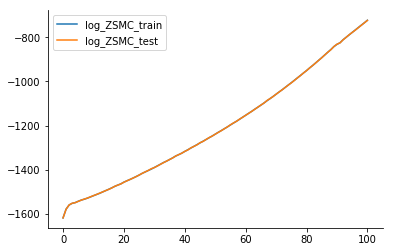

SystemExit: 

F:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [20]:
tf.app.run()

## Results

In [19]:
# get the dir storing results
import os
def all_subdirs_of(b='.'):
    result = []
    for d in os.listdir(b):
        bd = os.path.join(b, d)
        if os.path.isdir(bd): result.append(bd)
    return result
rslt_dirs = all_subdirs_of(os.path.join('rslts', rslt_dir_name))
rslt_dir = max(rslt_dirs, key=os.path.getmtime)
epoch_data_dirs = all_subdirs_of(os.path.join(os.path.join('rslts', 'epoch_data'), rslt_dir_name))
epoch_data_dir = max(epoch_data_dirs, key=os.path.getmtime)
print("Result Directory: {}".format(rslt_dir))
print("Epoch Data Directory: {}".format(epoch_data_dir))

Result Directory: rslts\notebook\D190628_001059_np_16_t_200_bs_1_lr_0.0002_epoch_100_seed_0
Epoch Data Directory: rslts\epoch_data\notebook\D190628_001059_np_16_t_200_bs_1_lr_0.0002_epoch_100_seed_0


#### ELBO across epochs

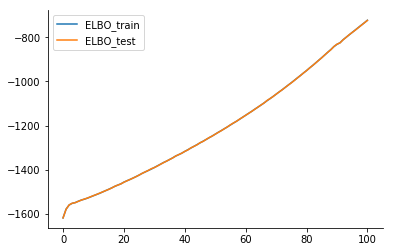

In [20]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

with open(os.path.join(rslt_dir, "history.json"), "r") as f:
    history = json.load(f)
ELBO_train = history["log_ZSMC_trains"]
ELBO_test  = history["log_ZSMC_tests"]
epochs = np.arange(len(ELBO_test)) * print_freq
plt.figure()
plt.plot(epochs, ELBO_train)
plt.plot(epochs, ELBO_test)
plt.legend(["ELBO_train", "ELBO_test"])
sns.despine()
plt.show()

#### Learned dynamics and inferred hidden states

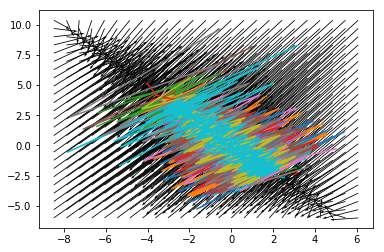

In [21]:
import pickle

with open(os.path.join(epoch_data_dir, "lattice_val_{}.p".format(epoch)), "rb") as f:
    lattice_dict = pickle.load(f)
X_trajs = lattice_dict["X_trajs"]
X = lattice_dict["X"]
nextX = lattice_dict["nextX"]

plt.figure()
for X_traj in X_trajs[0:saving_num]:
    plt.plot(X_traj[:, 0], X_traj[:, 1])
    plt.scatter(X_traj[0, 0], X_traj[0, 1])

axes = plt.gca()
x1range, x2range = axes.get_xlim(), axes.get_ylim()
scale = int(5 / 3 * max(abs(x1range[0]) + abs(x1range[1]), abs(x2range[0]) + abs(x2range[1])))
plt.quiver(X[:, :, 0], X[:, :, 1], nextX[:, :, 0] - X[:, :, 0], nextX[:, :, 1] - X[:, :, 1], scale=scale)

#### k-step R-sqaure

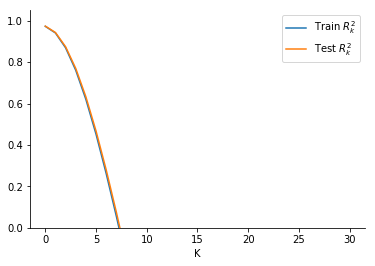

In [22]:
with open(os.path.join(epoch_data_dir, "metric_{}.p".format(epoch)), "rb") as f:
    metric_dict = pickle.load(f)
R_square_train, R_square_test = metric_dict["R_square_train"], metric_dict["R_square_test"]
plt.figure()
plt.plot(R_square_train)
plt.plot(R_square_test)
plt.ylim([0.0, 1.05])
plt.xlabel("K")
plt.legend(["Train $R^2_k$", "Test $R^2_k$"], loc='best')
sns.despine()
plt.show()